# Pytorch Segmentation + CAM
In the first part, we're going to use Deep Learning for a new task: semantic segmentation. In the second part, we will interpret networks with the class activation map (CAM).

## Semantic segmentation
The goal of semantic segmentation is to classify each pixel of the image to a corresponding class of what the pixel represent. One major diference between semantic segmentation and classification is that for semantic segmentation, model output a label for each pixel instead of a single label for the whole image.

## CMP Facade Database and Visualize Samples
We use a new dataset named: CMP Facade Database for semantic segmentation. This dataset is made up with 606 rectified images of the facade of various buildings. The facades are from different cities arount the world with different architectural styles.

CMP Facade DB include 12 semantic classes:

* facade 
* molding
* cornice
* pillar
* window
* door
* sill
* blind
* balcony
* shop
* deco
* background

In this assignment, we should use a model to classify each pixel in images to one of these 12 classes.

For more detail about CMP Facade Dataset, if you are intereseted, please check: https://cmp.felk.cvut.cz/~tylecr1/facade/

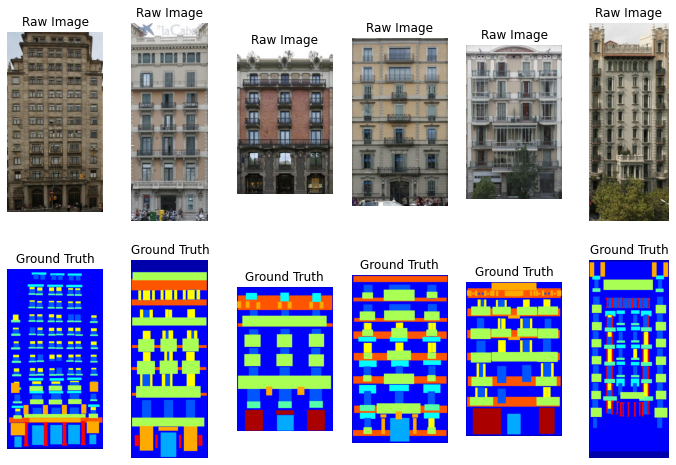

In [1]:
import matplotlib.pyplot as plt
import numpy as np

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")

## Build Dataloader and Set Up Device

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os
# import os.path as osp

from FCN.dataset import CMP_Facade_DB

os.environ["CUDA_VISIBLE_DEVICES"]="0"


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = os.path.join(
            root_dir, name
        )
        data_list += sorted(
            os.path.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=False
)



USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76
using device: cuda


## Fully Convolutional Networks for Semantic Segmentation

Here we are going to explore the classical work: "Fully Convolutional Networks for Semantic Segmentation"(FCN).

In FCN, the model uses the Transpose Convolution layers, which we've already learned during the lecture, to recover high resolution feature maps. For the overall introduction of Transpose Convolution and Fully Convolutional Networks, please review the lecture recording and lecture slides on Canvas(Lecture 10).

Here we do not cover all the details in FCN. Please check the original paper: https://arxiv.org/pdf/1411.4038.pdf for more details.

Besides of transpose Convolution, there are also some differences compared with the models we've been working on:

* Use 1x1 Convolution to replace fully connected layers to output score for each class.
* Use skip connection to combine high-level feature and local feature.


# Part 1: FCN-32s

We first try to implement simple version of FCN without skip connection (i.e., FCN-32s) with VGG-16 as the backbone. 

Compared with VGG-16, FCN-32s 
* replaces the fully connecteed layers with 1x1 convolution 
* adds a Transpose Convolution at the end to output dense prediction.

## 1.1 FC-32s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The transpose convolution: kernal size = 64, stride = 32, bias = False
* [transpose_conv(n_class, n_class)]

In [3]:
class FCN32s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN32s, self).__init__()

        # Convolutional layers
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=150)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout2d(p=0.5)

        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout2d(p=0.5)

        self.score = nn.Conv2d(4096, n_class, kernel_size=1)

        # Transpose convolution
        self.transpose_conv = nn.ConvTranspose2d(n_class, n_class, kernel_size=64, stride=32, bias=False)

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):

        # Encoder
        in_ = x

        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)

        x = self.relu3_1(self.conv3_1(x))
        x = self.relu3_2(self.conv3_2(x))
        x = self.relu3_3(self.conv3_3(x))
        x = self.pool3(x)

        x = self.relu4_1(self.conv4_1(x))
        x = self.relu4_2(self.conv4_2(x))
        x = self.relu4_3(self.conv4_3(x))
        x = self.pool4(x)

        x = self.relu5_1(self.conv5_1(x))
        x = self.relu5_2(self.conv5_2(x))
        x = self.relu5_3(self.conv5_3(x))
        x = self.pool5(x)

        # Decoder
        x = self.relu6(self.fc6(x))
        x = self.dropout6(x)

        x = self.relu7(self.fc7(x))
        x = self.dropout7(x)

        score = self.score(x)

        # Transpose convolution
        output = self.transpose_conv(score)

        h = output[:, :, 19:19 + in_.size(2), 19:19 + in_.size(3)]

        return h

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


## 1.2  Train FCN-32s from scratch

In [4]:
from FCN.trainer import Trainer

model32 = FCN32s(n_class=12)
model32.to(device)

best_model = Trainer(
    model32,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10
)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 2.431, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 1
Epoch Loss: 2.202, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 2
Epoch Loss: 2.006, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 3
Epoch Loss: 1.943, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 4
Epoch Loss: 1.93, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 5
Epoch Loss: 1.925, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 6
Epoch Loss: 1.922, Avg Acc: 0.3432, Mean IoU: 0.02862
Epochs: 7
Epoch Loss: 1.92, Avg Acc: 0.3439, Mean IoU: 0.02892
Epochs: 8
Epoch Loss: 1.918, Avg Acc: 0.3455, Mean IoU: 0.02956
Epochs: 9
Epoch Loss: 1.916, Avg Acc: 0.3475, Mean IoU: 0.03035
Test Acc: 0.3475, Test Mean IoU: 0.03035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


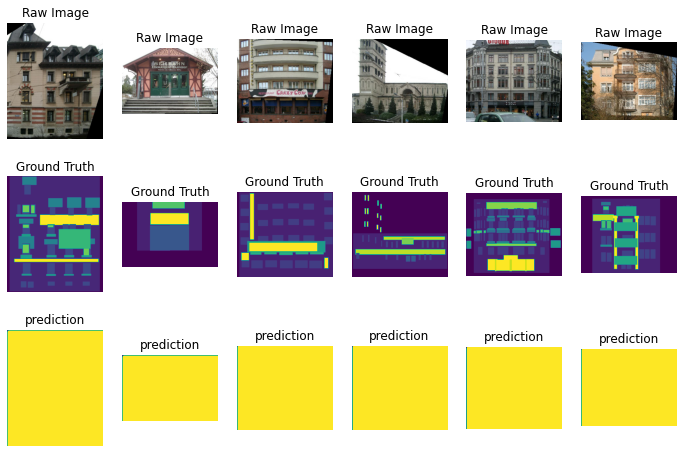

In [5]:
from FCN.trainer import visualize
visualize(best_model, test_loader)

## 1.3 Train FCN-32s with the pretrained VGG16 weights

In [4]:
import torchvision
from FCN.trainer import Trainer

vgg16 = torchvision.models.vgg16(pretrained=True)

model32_pretrain = FCN32s(n_class=12)
model32_pretrain.copy_params_from_vgg16(vgg16)
model32_pretrain.to(device)

best_model_pretrain = Trainer(
    model32_pretrain,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 1.642, Avg Acc: 0.4968, Mean IoU: 0.1288
Epochs: 1
Epoch Loss: 1.395, Avg Acc: 0.5214, Mean IoU: 0.1754
Epochs: 2
Epoch Loss: 1.264, Avg Acc: 0.5089, Mean IoU: 0.1707
Epochs: 3
Epoch Loss: 1.155, Avg Acc: 0.5611, Mean IoU: 0.233
Epochs: 4
Epoch Loss: 1.075, Avg Acc: 0.5791, Mean IoU: 0.2281
Epochs: 5
Epoch Loss: 1.006, Avg Acc: 0.5996, Mean IoU: 0.2924
Epochs: 6
Epoch Loss: 0.9158, Avg Acc: 0.6154, Mean IoU: 0.3154
Epochs: 7
Epoch Loss: 0.8403, Avg Acc: 0.6257, Mean IoU: 0.296
Epochs: 8
Epoch Loss: 0.7895, Avg Acc: 0.6061, Mean IoU: 0.316
Epochs: 9
Epoch Loss: 0.7462, Avg Acc: 0.633, Mean IoU: 0.3234
Epochs: 10
Epoch Loss: 0.7049, Avg Acc: 0.641, Mean IoU: 0.3492
Epochs: 11
Epoch Loss: 0.6706, Avg Acc: 0.654, Mean IoU: 0.354
Epochs: 12
Epoch Loss: 0.6334, Avg Acc: 0.6476, Mean IoU: 0.328
Epochs: 13
Epoch Loss: 0.6234, Avg Acc: 0.658, Mean IoU: 0.3643
Epochs: 14
Epoch Loss: 0.5851, Avg Acc: 0.6658, Mean IoU: 0.3938
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


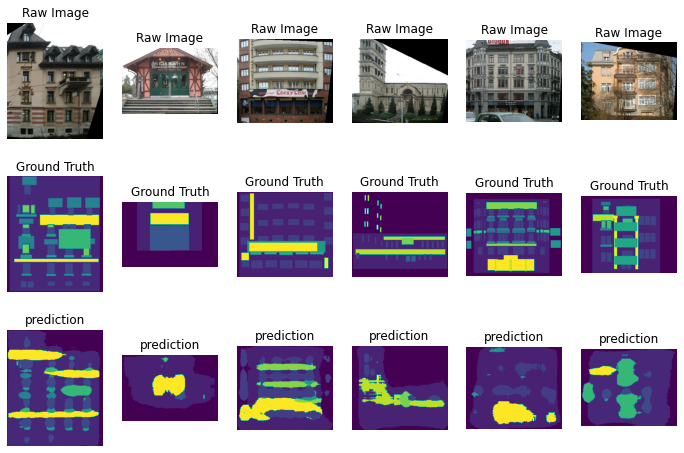

In [5]:
from FCN.trainer import visualize
visualize(best_model_pretrain, test_loader)

# Part 2: FCN-8s

In this section, we explore with another technique introduced in FCN paper: Skip Connection.


## The structure of FCN-8s, the variant of FCN with skip connections.

FCN-8s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

**As you can see, the structure of this part is the same as FCN-32s**

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)] 
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The Additional Score Pool use kernel size = 1, stride = 1, padding = 0
* [score_pool_3 =conv1x1(256, num_classes)]
* [score_pool_4 =conv1x1(512, num_classes)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore1 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore2 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 16, stride = 8, bias = False
* [upscore3 = transpose_conv(n_class, n_class)]


Different from FCN-32s which has only single path from input to output, there are multiple data path from input to output in FCN-8s.

The following graph is from original FCN paper, you can also find the graph there.

!["Architecture Graph"](files/arch.png)
"Layers are shown as grids that reveal relative spatial coarseness. Only pooling and prediction layers are shown; intermediate convolution layers (including converted fully connected layers) are omitted. " ---- FCN

Detailed path specification:

* score_pool_3
    * input: output from layer "pool3"
    * take [9: 9 + upscore2_width], [9: 9 + upscore2_height]
    
* score_pool_4,
    * input: output from layer "pool4"
    * take [5: 5 + upscore1_width], [5: 5 + upscore1_height]


* upscore1
    * input: output from layer "score"

* upscore2:
    * input: output from layer "score_pool_4" + output from layer "upscore1"

* upscore3:
    * input: output from layer "score_pool_3" + output from layer "upscore2"
    * take [31: 31 + input_image_width], [31: 31 + input_image_height]


In [6]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        # Encoder
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Convolutional Layers
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout2d(p=0.5)

        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout2d(p=0.5)

        self.score = nn.Conv2d(4096, n_class, kernel_size=1)

        # Upsampling layers
        self.score_pool3 = nn.Conv2d(256, n_class, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, n_class, kernel_size=1)

        self.upscore1 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        self.upscore3 = nn.ConvTranspose2d(n_class, n_class, kernel_size=16, stride=8, bias=False)

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

                
    def forward(self, x):
        
        # Encoder
        in_ = x
        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)

        x = self.relu3_1(self.conv3_1(x))
        x = self.relu3_2(self.conv3_2(x))
        x = self.relu3_3(self.conv3_3(x))
        x = self.pool3(x)
        pool3 = x

        x = self.relu4_1(self.conv4_1(x))
        x = self.relu4_2(self.conv4_2(x))
        x = self.relu4_3(self.conv4_3(x))
        x = self.pool4(x)
        pool4 = x

        x = self.relu5_1(self.conv5_1(x))
        x = self.relu5_2(self.conv5_2(x))
        x = self.relu5_3(self.conv5_3(x))
        x = self.pool5(x)

        # Fully Convolutional Layers
        x = self.dropout6(self.relu6(self.fc6(x)))
        x = self.dropout7(self.relu7(self.fc7(x)))
        score = self.score(x)
        
        # Upsampling
        score_pool3 = self.score_pool3(pool3)
        score_pool4 = self.score_pool4(pool4)
        
        upscore1 = self.upscore1(score)
        upscore2 = self.upscore2(score_pool4[:, :, 5:5 + upscore1.size(2), 5:5 + upscore1.size(3)] + upscore1) 
        upscore3 = self.upscore3(score_pool3[:, :, 9:9 + upscore2.size(2), 9:9 + upscore2.size(3)] + upscore2)

        h = upscore3[:, :, 31:31 + in_.size(2), 31:31 + in_.size(3)]

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [7]:
from FCN.trainer import Trainer
import torchvision

vgg16 = torchvision.models.vgg16(pretrained=True)

model8 = FCN8s(n_class=12)
model8.copy_params_from_vgg16(vgg16)
model8.to(device)

best_model_fcn8s = Trainer(
    model8,
    train_loader,
    val_loader,
    test_loader, 
    num_epochs=20
)

Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 1.188, Avg Acc: 0.6258, Mean IoU: 0.3168
Epochs: 1
Epoch Loss: 0.9537, Avg Acc: 0.6582, Mean IoU: 0.3551
Epochs: 2
Epoch Loss: 0.8627, Avg Acc: 0.6675, Mean IoU: 0.3908
Epochs: 3
Epoch Loss: 0.7888, Avg Acc: 0.6798, Mean IoU: 0.3987
Epochs: 4
Epoch Loss: 0.7317, Avg Acc: 0.6905, Mean IoU: 0.3802
Epochs: 5
Epoch Loss: 0.6711, Avg Acc: 0.7031, Mean IoU: 0.4148
Epochs: 6
Epoch Loss: 0.6133, Avg Acc: 0.7107, Mean IoU: 0.4314
Epochs: 7
Epoch Loss: 0.5463, Avg Acc: 0.7208, Mean IoU: 0.4398
Epochs: 8
Epoch Loss: 0.516, Avg Acc: 0.72, Mean IoU: 0.4528
Epochs: 9
Epoch Loss: 0.4938, Avg Acc: 0.715, Mean IoU: 0.4414
Epochs: 10
Epoch Loss: 0.4721, Avg Acc: 0.6867, Mean IoU: 0.411
Epochs: 11
Epoch Loss: 0.4585, Avg Acc: 0.7211, Mean IoU: 0.4657
Epochs: 12
Epoch Loss: 0.3973, Avg Acc: 0.7247, Mean IoU: 0.4407
Epochs: 13
Epoch Loss: 0.3663, Avg Acc: 0.7293, Mean IoU: 0.4461
Epochs: 14
Epoch Loss: 0.3485, Avg Acc: 0.7302, Mean IoU: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


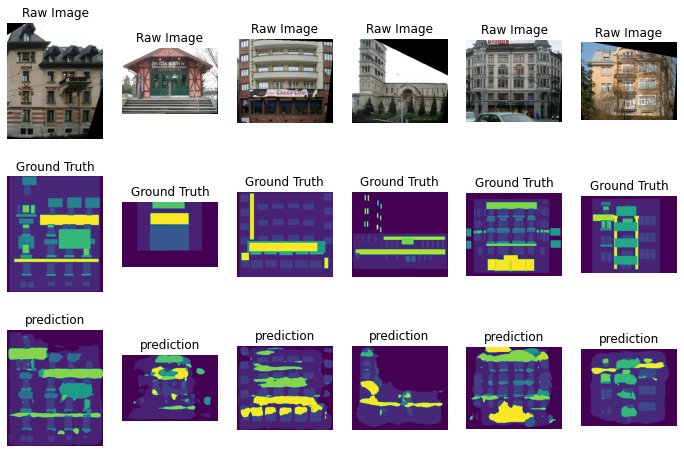

In [8]:
from FCN.trainer import visualize
visualize(best_model_fcn8s, test_loader)

# Part 3:  Observations:

We see that FCN-32s with pretrained weight is giving us better accuracy and mean IoU compared to training from scratch. Pretrained weights definitely helped in improving the model performance as they are obtained by training a large scale dataset and after several iterations. In case of training from scratch, we ran the model only for 10 epochs which is way more less compared to the pretrained weights training.

FCN-8s is outperforming FCN-32s in terms of accuracy and mean IoU. The visualizations for FCN-8s are more accurate and precise with sharper boundaries, this shows that FCN-8s are able to capture global as well as local details more accuratelly compared to FCN-32s.

# Part 4: Class Activation Maps

In this section, we are going to interpret neural networks decisions with the technique class activation maps (CAM). The idea is that one can highlight the image region that is important to the prediction. 

The resnet-18 uses global average pooling for downsampling layer 4 features and then applies an FC layer to predict the class probabilities. We select the class with the highest probability as our best guess and we denote the corresponding FC weight as $w$. 

Let $f_4(x,y)$ denote the layer 4 feature at spatial location (x,y). Now we can directly apply the learned FC weight $w$ to $f_4(x,y)$ to get the network prediction for this spatial location $CAM(x,y)$. $CAM$ can be obtained by repeating this for all spatial locations.

You may refer to the paper (http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) for more details. In this part, we are going to use the pretrained resnet18 as the backbone.

In [9]:
def get_cls_pred(logit):
    """
    Input:
        logit: (1, 1000) # the predicted logits from resnet18
    Output:
        cls_idx: (1, ) # the class index with highest probability
    """

    # load the imagenet category list
    LABELS_file = 'files/imagenet-simple-labels.json'
    with open(LABELS_file) as f:
        classes = json.load(f)
    
    pred_probs = torch.softmax(logit, dim=1)
    top1_prob, top1_idx = torch.max(pred_probs).item(),torch.argmax(pred_probs).item()
    
    # output the prediction
    print('top1 prediction: {:.3f} -> {}'.format(top1_prob, classes[top1_idx]))

    return top1_idx


def returnCAM(feature_conv, weight_fc, idx):
    """
    Input:
        feature_conv: (1, 512, 7, 7) # layer4 feature
        weight_fc: (1000, 512) # fc weight
        idx: (1, ) # predicted class index
    Output:
        output_cam: (256, 256)
    """
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape

    fc_weight = weight_fc[idx]

    cam_img = feature_conv * fc_weight.reshape(1, nc, 1, 1)

    cam_img = cam_img.squeeze().sum(axis=0)  # Sum along the channel dimension
    cam_img = (cam_img - np.min(cam_img)) / (np.max(cam_img) - np.min(cam_img))  # Normalize
    cam_img = np.uint8(cam_img * 255)
    
    # resize cam image to (256,256)
    output_cam = cv2.resize(cam_img, size_upsample)

    return output_cam

load pretrained weights
top1 prediction: 0.444 -> mountain bike


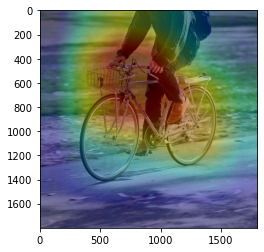

top1 prediction: 0.370 -> tabby cat


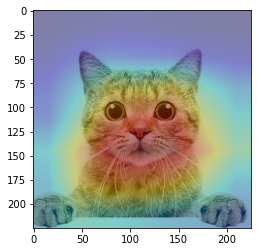

In [10]:
import io
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
import numpy as np
import cv2
import json
from CAM.resnet import resnet18
import matplotlib.pyplot as plt


# load model
net = resnet18(pretrained=True)
net.eval()

# image normalization
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])
])

# load the imagenet category list
LABELS_file = 'files/imagenet-simple-labels.json'
with open(LABELS_file) as f:
    classes = json.load(f)

# load test image files/bike.jpg, files/
for image_file in ['files/bike.jpg', 'files/cat.jpg']:
    img = Image.open(image_file)
    img_tensor = preprocess(img)

    # extract predicted logits and layer4 feature
    logits, layer4_feat = net(img_tensor.unsqueeze(0))
    layer4_feat = layer4_feat.detach().numpy()

    # predicted top-1 class, needs to complete the function
    cls_idx = get_cls_pred(logits)

    weight_fc =  net.fc.weight.detach().numpy() # weight_fc is of shape (1000, 512)
    
    # generate class activation mapping for the top1 prediction
    CAMs = returnCAM(layer4_feat, weight_fc, cls_idx)

    # render the CAM and output
    img = cv2.imread(image_file)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    plt.imshow(result[:,:,::-1]/255)
    plt.show()